In [23]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230120',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }


In [5]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-01-01' and '2023-01-07'
    and exp_group in (0,1,2,3)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
0,9999,9999,9999,9999
1,10079,10079,10079,10079
2,9952,9952,9952,9952
3,10049,10049,10049,10049


In [46]:
def linearized_ctr(df, groups,test):
    '''
    Принимает на вход группы для сравнения и тест, с помощью которого будет производится проверки гипотезы
    '''
    # Подготовка датасета
    test_1 = df[df['exp_group'].isin(groups)]
    ctr_0 = df[df['exp_group']==groups[0]].likes.sum()/df[df['exp_group']==groups[0]].views.sum()
    
    test_1['lin_ctr'] = test_1.apply(lambda x: x['likes'] - ctr_0*x['views'], axis=1)
    
    #Отрисовка графиков для сравнения распределений
    f, ax = plt.subplots(1,2, figsize=(12,6))
    ax1 = sns.histplot(data = test_1, 
                  x='ctr', 
                  hue='exp_group', 
                  palette = ['r', 'b'],
                  alpha=0.5,
                  kde=False,
                ax=ax[0])
    ax1.set_title('Users CTR')
    ax2 = sns.histplot(data = test_1, 
                  x='lin_ctr', 
                  hue='exp_group', 
                  palette = ['r', 'b'],
                  alpha=0.5,
                  kde=False,
                  ax= ax[1])
    ax2.set_title('Users linearized CTR')
    
    #Сравнение Т-тестом
    if test=='ttest':
        default_p = stats.ttest_ind(test_1[test_1.exp_group == groups[0]].ctr,
                        test_1[test_1.exp_group == groups[1]].ctr,
                        equal_var=False).pvalue

        lin_p = stats.ttest_ind(test_1[test_1.exp_group == groups[0]].lin_ctr,
                            test_1[test_1.exp_group == groups[1]].lin_ctr,
                            equal_var=False).pvalue
    if test=='mw':
        default_p = stats.mannwhitneyu(test_1[test_1.exp_group == groups[0]].ctr,
                    test_1[test_1.exp_group == groups[1]].ctr,
                    alternative='two-sided').pvalue

        lin_p = stats.mannwhitneyu(test_1[test_1.exp_group == groups[0]].lin_ctr,
                    test_1[test_1.exp_group == groups[1]].lin_ctr,
                    alternative='two-sided').pvalue
    print(f'P-value для теста на поюзерных ctr {default_p}, а для линеаризованного ctr p-value = {lin_p}')

## Сравнение групп 0 и 3
Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

Распределение близко к нормальному, можно сразу попробовать t-test

/tmp/ipykernel_116/856642825.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_1['lin_ctr'] = test_1.apply(lambda x: x['likes'] - ctr_0*x['views'], axis=1)


P-value для теста на поюзерных ctr 1.055849414662529e-43, а для линеаризованного ctr p-value = 5.4914249479690016e-52


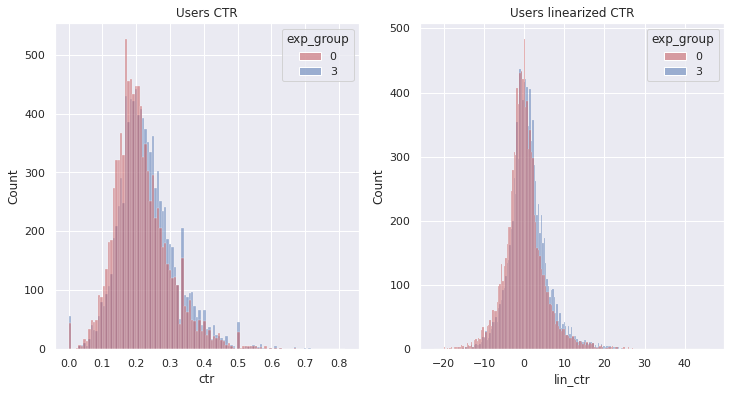

In [44]:
linearized_ctr(df,[0,3],'ttest')

P-value для линеаризованной версии CTR стало сильно меньше. Тест во втором случае отработал лучше, т.к. метрика стала более "гладкая" (меньше выбросов и нет сдвига, в отличии от исходного распределения). Однако в данном случае тест и на исходных данных работал довольно хорошо.

## Сравнение групп 1 и 2
Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

/tmp/ipykernel_116/2838627553.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_1['lin_ctr'] = test_1.apply(lambda x: x['likes'] - ctr_0*x['views'], axis=1)


P-value для теста на поюзерных ctr 6.0376484617779035e-56, а для линеаризованного ctr p-value = 9.404319579641738e-27


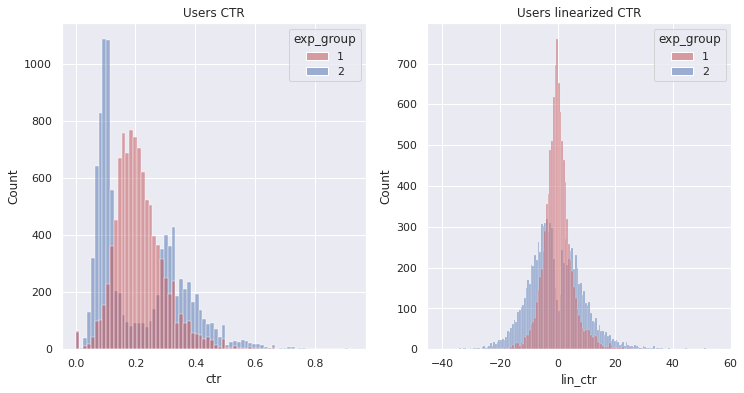

In [47]:
linearized_ctr(df,[1,2],'mw')

А вот в данном случае трюк сработал в минус: линеаризация "стянула" нам распределение, за счет чего p-value больше, чем в тесте с исходными данными.  
Однако тест все равно прокрасился в обоих случаях.